# Introduction: Backward Sensitivities (Adjoint/VJP) in AIFS with Anemoi Inference

This notebook demonstrates how to use the Anemoi inference framework to analyze the sensitivity of the Artificial Intelligence Forecasting System (AIFS) to changes in its input values, focusing on backward sensitivities—also known as adjoint or vector-Jacobian product (VJP) analysis.

**What are backward sensitivities?**
Backward sensitivities answer questions like:
*"What would a 1K perturbation in the t2m (2-meter temperature) forecast for day-10 around Reading trace back to in the current atmospheric conditions, up to first order?"*

This analysis computes how a small change in a future forecast (e.g., temperature at a specific location and time) can be traced back to the present atmospheric state. This is crucial for understanding which current features most influence future predictions and for model validation and improvement.

**How does the perturbation work?**
The perturbation created in this notebook applies a change to all data points within a specified radius around a chosen location. This allows us to study the spatial impact of localized changes and how they propagate backward through the model.

**What will you learn?**
By visualizing these sensitivities, we gain insight into the regions and variables in the current state that most affect the forecast at the target location and time. We will use the `anemoi.inference.runners.sensitivities.SensitivitiesRunner` to compute sensitivities and explore how different input perturbations influence the forecast results.

AIFS leverages machine learning and numerical weather prediction data to provide advanced forecasts. Sensitivity analysis helps us understand how variations in input parameters affect the model's outputs, which is crucial for model validation and improvement.

## Step-by-Step Sensitivity Analysis Workflow

1. **Import Libraries and Modules**
   
Load required Python libraries and Anemoi modules for sensitivity analysis and plotting.



In [2]:
import logging
import torch
import os
import warnings
from typing import Any
from ecmwf.opendata import Client as OpendataClient

from anemoi.inference.outputs.printer import print_state
from perturbantion import Perturbation
from sensitivities import SensitivitiesRunner

from helpers import load_input_state, save_state
from helpers import haversine
from helpers import compute_sensitivities_statistics
from plotting import plot_sensitivities
from plotting import plot_summary_sfc
from plotting import plot_summary_pl
from plotting import plot_cross_section

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['ANEMOI_INFERENCE_NUM_CHUNKS'] = '16'

warnings.filterwarnings('ignore')

LOGGER = logging.getLogger(__name__)

assert torch.cuda.is_available(), "CUDA is not available. Please check your GPU setup."

2. **Set Up Experiment Date and Model Checkpoint**

Select the forecast date and specify the model checkpoint to use for inference. We recommend an "o96" model (~1 deg) to make sure the model fits into 1 GPU.


In [3]:
DATE = OpendataClient().latest()
# import datetime
# DATE = datetime.datetime(2025, 8, 29, 6, 0)

from pathlib import Path
import subprocess

In [4]:
url = "https://object-store.os-api.cci1.ecmwf.int/ml-tests/test-data/samples/training-course/inference-aifs-o48-cpu.ckpt"
ckpt_file = "/home/student/2025-ml-training/5-xAI-with-AIFS/aifs-global-o48-cpu.ckpt"

# Create the output directory 
Path(ckpt_file).parent.mkdir(parents=True, exist_ok=True)

# Download the checkpoint
if not Path(ckpt_file).exists():
    process = subprocess.run(
        ["wget", url, "-O", ckpt_file],
        capture_output=True,
        text=True
    )
    print(process.stdout)
    print(process.stderr)
else:
    print(f"Checkpoint already exists in {ckpt_file}")


Checkpoint already exists in /home/student/2025-ml-training/5-xAI-with-AIFS/aifs-global-o48-cpu.ckpt


3. **Load Initial Atmospheric State**

Retrieve the input state for the selected date using helper functions.
- Print the loaded state for inspection.

In [5]:
# Load initial conditions
input_state = load_input_state(DATE, resolution="O48")
print_state(input_state)


😀 date=2025-10-30T00:00:00 fields=90

    10u    shape=(2, 10944) min=-24.8247       max=26.6756       
    t_150  shape=(2, 10944) min=199.501        max=232.12        
    v_400  shape=(2, 10944) min=-56.5153       max=48.6806       
    q_850  shape=(2, 10944) min=3.62166e-08    max=0.0184587     
    z_100  shape=(2, 10944) min=145252         max=163649        
    z_50   shape=(2, 10944) min=185909         max=203845        



4. **Initialize Sensitivity Runner**

Create a `SensitivitiesRunner` instance with the chosen checkpoint and device (GPU).

In [6]:
# Create runner
runner = SensitivitiesRunner(
    ckpt_file, 
    device="cpu",
    perturb_normalised_space=True,
    return_unnormalised_sensitivities=False
)

5. **Define Perturbation**

The class `LocalPerturbation` is used here to create a local perturbation, but this class can be extended to implement other types of perturbations as needed for different experiments.
- Specify the variable to perturb (e.g., 2-meter temperature), location (latitude, longitude), and radius (km) for the perturbation.
- The perturbation will affect all data points within the defined radius.
- This perturbation adds 1 in the normalised spaced of the target.

In [7]:
class LocalPerturbation(Perturbation):
    """Perturbation class."""

    def __init__(
        self,
        checkpoint: str,
        perturbed_variable: str,
        perturbation_location: float,
        perturbation_radius_km: float = 100.0,
        patch_metadata: dict[str, Any] = {},
    ) -> None:
        super().__init__(checkpoint, patch_metadata=patch_metadata)

        assert len(perturbation_location) == 2, "perturbation_location must be a tuple of (lat, lon)"
        assert perturbation_location[0] >= -90 and perturbation_location[0] <= 90, "Latitude must be between -90 and 90"
        assert perturbation_location[1] >= 0 and perturbation_location[1] <= 360, "Longitude must be between 0 and 360"

        self.perturbed_variable = perturbed_variable
        self.perturbation_location = torch.tensor(perturbation_location)
        self.perturbation_radius_km = perturbation_radius_km

    def create(self, *args, **kwargs) -> torch.Tensor:
        """Get the perturbation data."""
        var_idx = self.variable_to_output_tensor_index[self.perturbed_variable]
        perturbation = torch.zeros(self.output_shape)

        # Get index of the closest point
        dists = haversine(self.coords, self.perturbation_location)
        closest_idx = torch.where(dists < self.perturbation_radius_km)[0]

        assert len(closest_idx) > 0, "No grid points found within the specified perturbation radius."

        perturbation[..., closest_idx, var_idx] = 1.0
        return perturbation

In [8]:
perturbation = LocalPerturbation(
    ckpt_file,
    perturbed_variable="2t",
    perturbation_location=(40, 120), # (lat, lon)
    perturbation_radius_km=350.0
)


6. **Run Sensitivity Analysis**

Execute the runner to compute backward sensitivities for the given input state and perturbation.
- Only a 6-hour lead time is supported in this example.
- Print the computed sensitivities for review.

In [9]:
# Compute sensitivities
for sensitivities in runner.run(input_state=input_state, perturbation=perturbation, lead_time="6h"): # only 6h supported
    print_state(sensitivities)
    stats_df = compute_sensitivities_statistics(sensitivities)


😀 date=2025-10-30T06:00:00 latitudes=(10944,) longitudes=(10944,) fields=99

    q_50           shape=(2, 10944) min=-0.00706863    max=0.00907898    
    t_925          shape=(2, 10944) min=-0.0744019     max=0.126587      
    v_700          shape=(2, 10944) min=-0.0286102     max=0.00834656    
    z_500          shape=(2, 10944) min=-0.259033      max=0.0889282     
    sin_julian_day shape=(2, 10944) min=-0.0673218     max=0.0273743     
    insolation     shape=(2, 10944) min=-0.104126      max=0.0118027     



In [64]:
from helpers import load_state, save_state

ImportError: cannot import name 'load_state' from 'helpers' (/home/student/2025-ml-training/5-xAI-with-AIFS/helpers.py)

In [74]:
def load_state(state, outfile):
    with np.load(file, allow_pickle=False) as data:
        fields = {k: data[k] for k in data.files}

    state = {"date": date, "fields": fields, "latitudes": fields.pop("latitudes"), "longitudes": fields.pop("longitudes")}

def save_state(state, outfile):
    np.savez(outfile, **state["fields"], longitudes = state["longitudes"], latitudes = state["latitudes"])

In [75]:
save_state(sensitivities, 'sensitivities.npzload_state

KeyError: 'longitudes'

In [70]:
sensitivities = load_state('sensitivities.npz')

In [71]:
sensitivities

{'fields': {'q_50': array([[-6.5565109e-07,  1.3709068e-06, -6.5565109e-07, ...,
          -5.9604645e-08,  5.9604645e-08,  1.7881393e-07],
         [ 1.5497208e-06, -1.2516975e-06,  1.7285347e-06, ...,
          -1.7881393e-07, -2.3841858e-07, -3.5762787e-07]], dtype=float32),
  'q_100': array([[ 3.5762787e-07, -2.9802322e-07,  5.9604645e-08, ...,
          -5.9604645e-08,  1.1920929e-07,  2.3841858e-07],
         [-8.9406967e-07,  1.3709068e-06, -1.1920929e-07, ...,
          -5.9604645e-08, -1.7881393e-07, -1.1920929e-07]], dtype=float32),
  'q_150': array([[ 1.7881393e-07,  5.9604645e-08, -5.9604645e-08, ...,
          -5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
         [-6.5565109e-07,  5.3644180e-07, -3.5762787e-07, ...,
           2.9802322e-07, -2.9802322e-07, -4.1723251e-07]], dtype=float32),
  'q_200': array([[-7.1525574e-07, -3.5762787e-07, -7.1525574e-07, ...,
          -5.9604645e-08, -1.1920929e-07, -5.9604645e-08],
         [-8.9406967e-07,  8.9406967e-07, -1.01327

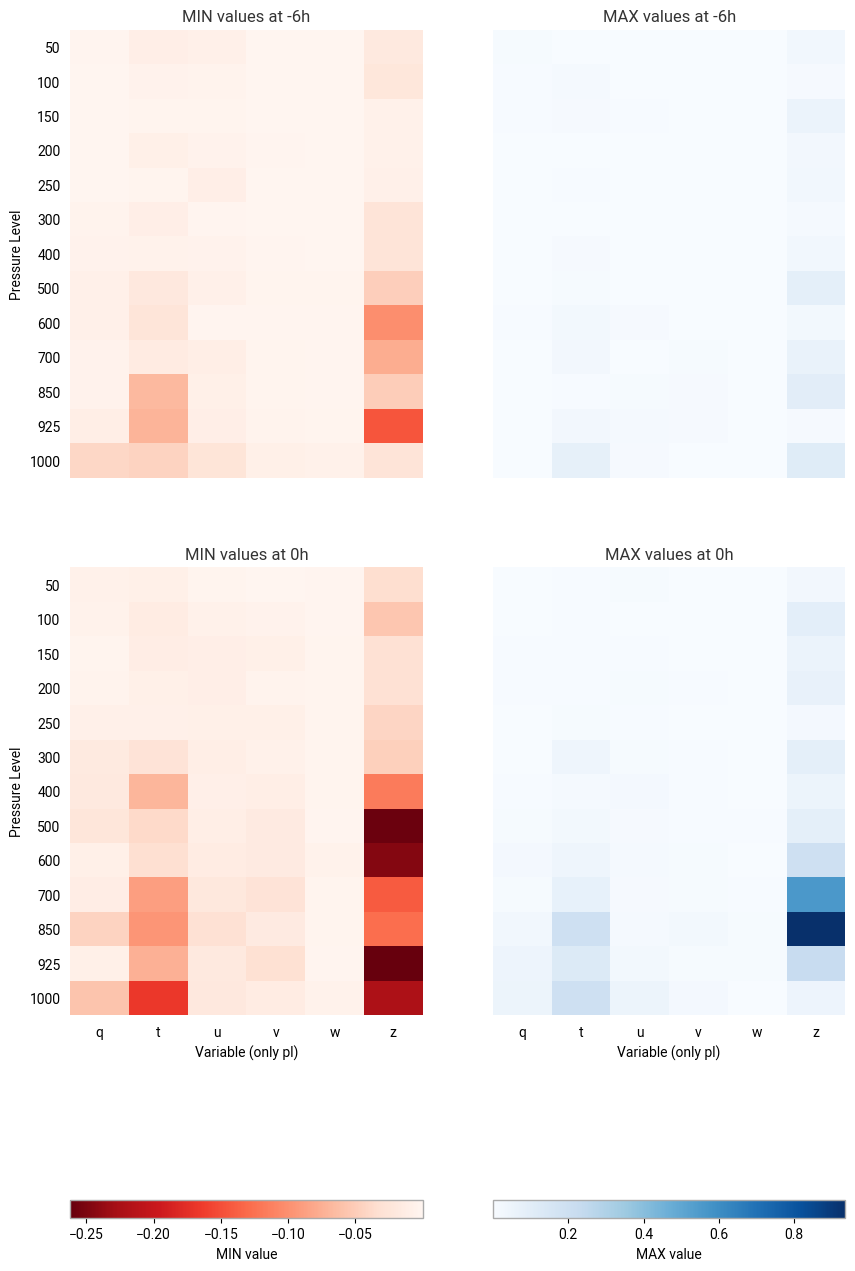

In [72]:
plot_summary_pl(stats_df, stats=["min", "max"], cmaps=dict(min="Reds_r", max="Blues"))

7. **Visualize Sensitivities**

Plot the sensitivities for the perturbed variable (e.g., "2t") to see which regions in the current state most influence the forecast.
   - Optionally, plot sensitivities for other variables (e.g., "z_500") and restrict the visualization to specific areas.

KeyError: 'longitudes'

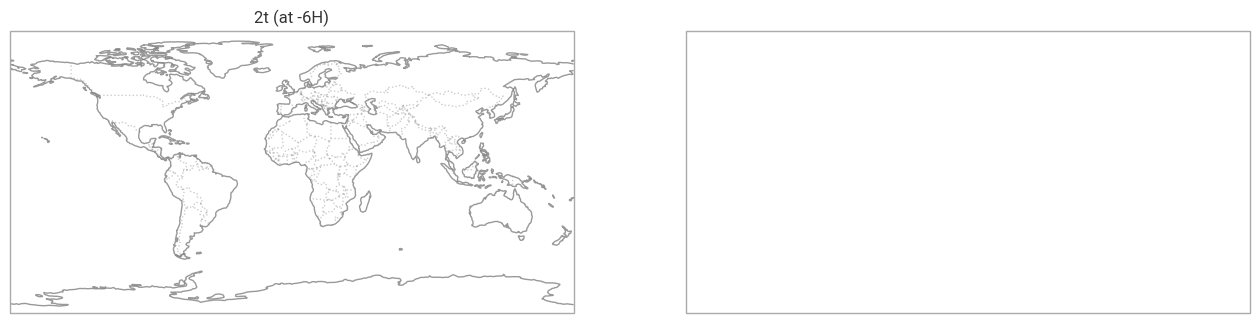

In [73]:
plot_sensitivities(sensitivities, "2t")

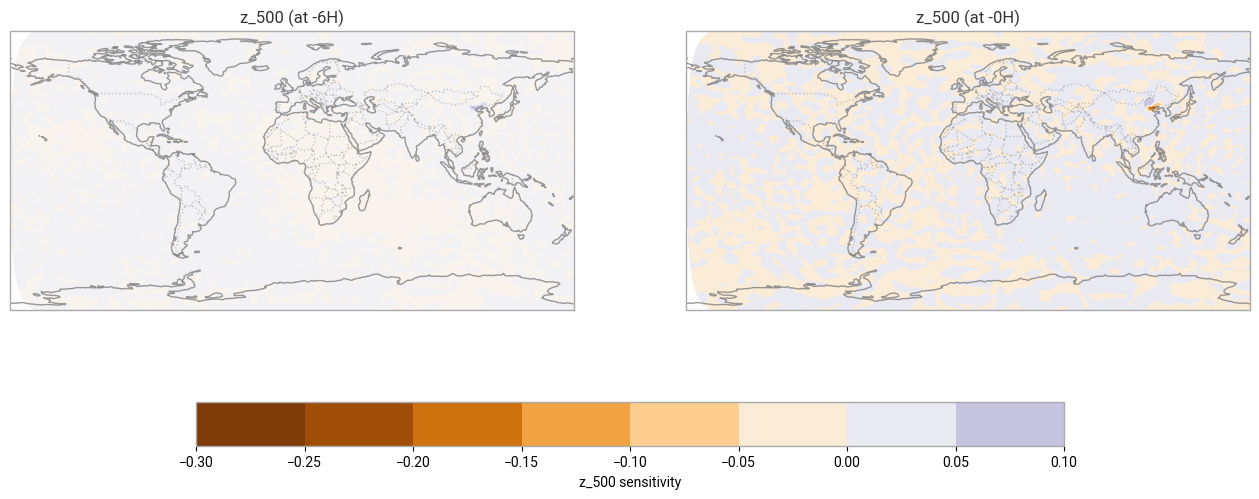

In [55]:
plot_sensitivities(sensitivities, "z_500")

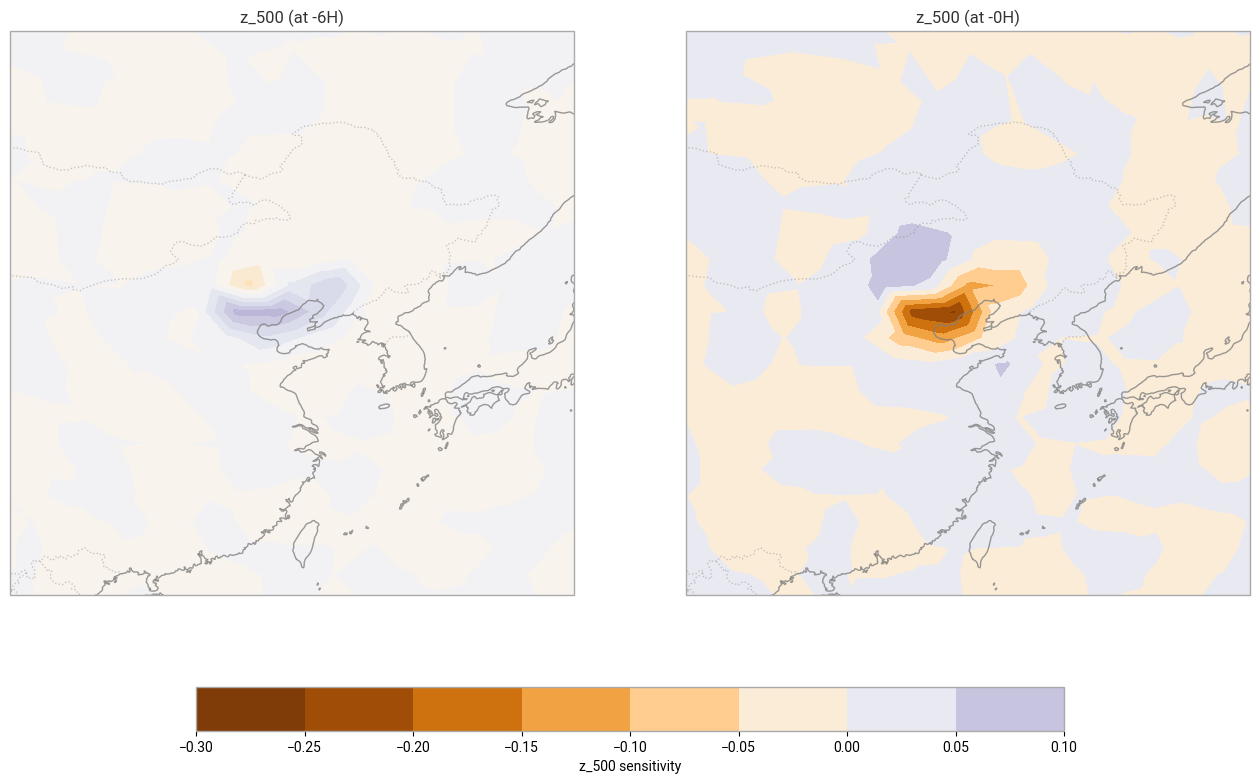

In [56]:
plot_sensitivities(sensitivities, "z_500", area=(100, 140, 20, 60))
# area=(left, right, bottom, top) = (lon_min, lon_max, lat_min, lat_max)

Plotting cross-section sensitivities at longitude=40.5° with 124 points at 13 pressure levels.


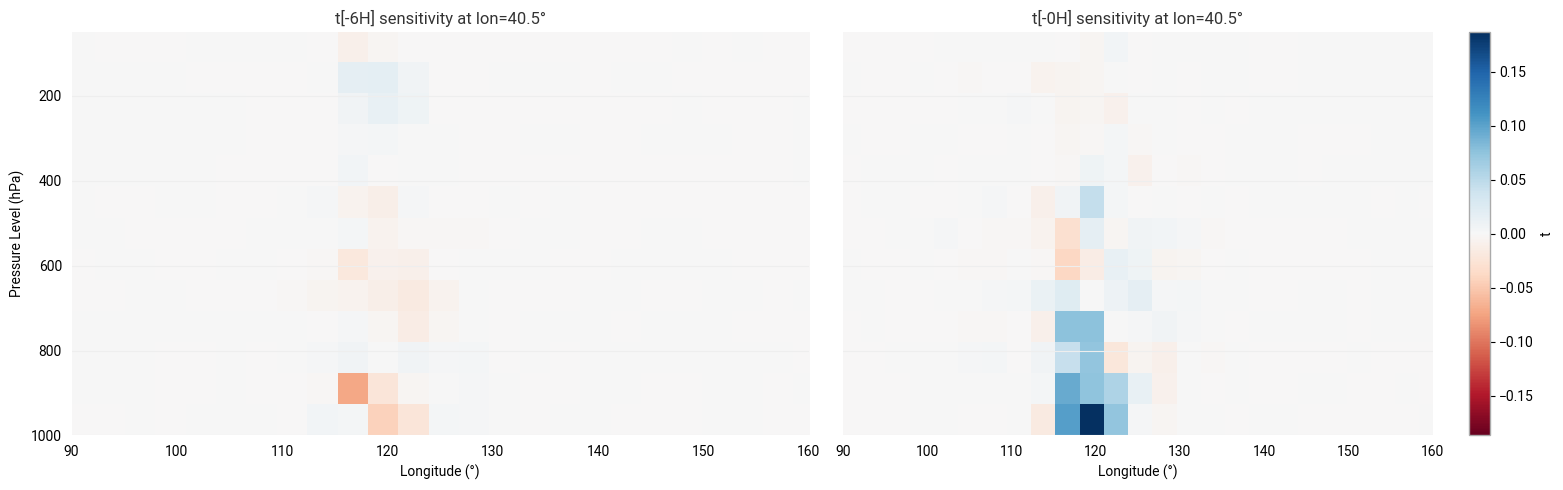

In [58]:
plot_cross_section("t", sensitivities, latitude=40.5, xlim=(90, 160), margin = 0.5)

### Task 5.1: Plot the sensitivities for another location

Change the location to your home town and have a look at how the sensitivities differ on different pressure levels of temperature when perturbing 2t.


### Task 5.2: Change the perturbation radius

How does this effect the sensitivies?

### Task 5.3: Implement your own Perturbation

For this task, you are asked to implement your own perturbation class. Instead of using the provided Perturbation base class directly, you should create a new class that inherits from it and overrides the create() method. Your implementation can generate any kind of perturbation you choose. Be creative and explore different spatial or variable patterns. A few examples:

- Specify a variable and perturb all pressure levels.
- Apply a perturbation to a latitude/longitude strip around the globe instead of a single grid point.
- Perturb the entire field rather than one specific location.

The goal is to experiment with how different perturbation structures affect the model behaviour.

In [ ]:
class MyPerturbation(Perturbation):
    """Perturbation class."""

    def __init__(
        self,
        checkpoint: str,
        *args, 
        **kwargs,
        patch_metadata: dict[str, Any] = {},
    ) -> None:
        super().__init__(checkpoint, patch_metadata=patch_metadata)

        ## TODO: Save attributes

    def create(self, *args, **kwargs) -> torch.Tensor:
        """Get the perturbation data."""
        perturbation = torch.zeros(self.output_shape)

        # TODO: Create your own perturbation
        return perturbation